In [1]:
import pandas as pd
import urllib
import numpy as np
import os
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

import utils
import ml

## Downloading dataset

In [2]:
df = utils.download_data(filename='dataset.csv')
df

dataset.csv already exists in the current directory.


,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL63786,3.000000e-03,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3,1,5.28910,True
1,CHEMBL35820,6.000000e-03,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5,1,4.93330,True
2,CHEMBL53711,6.000000e-03,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,5,1,3.59690,True
3,CHEMBL66031,8.000000e-03,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,4,2,4.01220,True
4,CHEMBL53753,8.000000e-03,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,5,2,3.57260,True
...,...,...,...,...,...,...,...,...,...,...
4630,CHEMBL120564,2.600000e+06,nM,COc1cc(C=C(C#N)C#N)cc(C)c1O,2.585027,214.074228,4,1,2.13978,True
4631,CHEMBL66879,3.000000e+06,nM,O=C(O)/C=C/c1ccc(O)cc1,2.522879,164.047344,2,2,1.49000,True
4632,CHEMBL261238,5.000000e+06,nM,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030,404.095250,6,1,5.20048,True
4633,CHEMBL76587,6.500000e+06,nM,N#CC(C#N)Cc1ccc(O)cc1,2.187087,172.063663,3,1,1.59806,True


In [167]:
df = df[["smiles", "pIC50"]]
# Add column for activity
df["active"] = np.zeros(len(df))

# Mark every molecule as active with an pIC50 of >= 8.0, 0 otherwise
pIC50_cut_off = 8.0
df.loc[df[df.pIC50 >= pIC50_cut_off].index, "active"] = 1.0
df

,smiles,pIC50,active
0,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,1.0
1,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,1.0
2,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,1.0
3,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,1.0
4,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,1.0
...,...,...,...
4630,COc1cc(C=C(C#N)C#N)cc(C)c1O,2.585027,0.0
4631,O=C(O)/C=C/c1ccc(O)cc1,2.522879,0.0
4632,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030,0.0
4633,N#CC(C#N)Cc1ccc(O)cc1,2.187087,0.0


## Features

In [168]:
df["finger print"] = df["smiles"].apply(utils.smiles_to_descriptors, type='morgan2')
df["selfies"] = df["smiles"].apply(utils.smiles_to_descriptors, type='selfies')

# Mordred takes forever to run, so just loading the pickled file!
morderd_file = 'saved_results/cleaned_up_mordred_descriptors.pkl'
if not os.path.exists(morderd_file):
    df['mordred'] = df["smiles"].apply(utils.smiles_to_descriptors, type='mordred')
    df['mordred'] = [list(array[0]) for array in df['mordred']]
    # Identify columns with NaN values
    nan_columns = np.isnan(np.vstack(df['mordred'])).any(axis=0)
    # Extract columns without NaN values
    mordred_array_without_nan = mordred_array[:, ~nan_columns]
    # dropping features with 0 std
    mask = mordred_array_without_nan.std(axis=0) != 0
    mordred_array_without_nan = mordred_array_without_nan[:, mask]
    df['mordred'] = mordred_array_without_nan.tolist()
    df['mordred'].to_pickle(morderd_file)
else:
    df['mordred'] = pd.read_pickle(morderd_file)
    mordred_features = np.vstack(df['mordred'])

df

,smiles,pIC50,active,finger print,selfies,mordred
0,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Br][C][=C][C][=C][C][Branch2][Ring1][=Branch1...,"[0.0, 0.0, 20.0, 22.0, 34.0, 22.0, 0.0, 0.0, 4..."
1,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[C][C][O][C][=C][C][=N][C][=N][C][Branch1][=N]...,"[0.0, 0.0, 16.0, 17.0, 42.0, 24.0, 0.0, 0.0, 6..."
2,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",[C][N][Branch1][C][C][C][=C][C][=C][Branch1][=...,"[0.0, 0.0, 16.0, 17.0, 35.0, 21.0, 0.0, 0.0, 6..."
3,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Br][C][=C][C][=C][C][Branch2][Ring1][Branch1]...,"[0.0, 0.0, 19.0, 21.0, 31.0, 21.0, 0.0, 0.0, 6..."
4,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",[C][N][C][=C][C][=C][Branch1][=N][N][C][=C][C]...,"[0.0, 0.0, 16.0, 17.0, 32.0, 20.0, 0.0, 0.0, 6..."
...,...,...,...,...,...,...
4630,COc1cc(C=C(C#N)C#N)cc(C)c1O,2.585027,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[C][O][C][=C][C][Branch1][=Branch2][C][=C][Bra...,"[0.0, 0.0, 6.0, 6.0, 26.0, 16.0, 0.0, 0.0, 4.0..."
4631,O=C(O)/C=C/c1ccc(O)cc1,2.522879,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[O][=C][Branch1][C][O][/C][=C][/C][=C][C][=C][...,"[1.0, 0.0, 6.0, 6.0, 20.0, 12.0, 0.0, 0.0, 3.0..."
4632,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",[C][N][Branch1][=Branch2][C][=C][C][=C][N][=C]...,"[0.0, 0.0, 22.0, 23.0, 43.0, 29.0, 0.0, 0.0, 8..."
4633,N#CC(C#N)Cc1ccc(O)cc1,2.187087,0.0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[N][#C][C][Branch1][Ring1][C][#N][C][C][=C][C]...,"[0.0, 0.0, 6.0, 6.0, 21.0, 13.0, 0.0, 0.0, 3.0..."


### RNN model features

Converting Smiles to SELFIES and creating an integer encoding for them selfies by tokenizing them:

In [169]:
import selfies as sf
alphabet = sf.get_alphabet_from_selfies(df['selfies'].to_list())
alphabet.add('[nop]') # This is a special padding symbol
alphabet.add('.')
alphabet = list(sorted(alphabet))
voc = {s: i for i, s in enumerate(alphabet)}
pad_to_len = max(sf.len_selfies(s) for s in df["selfies"])
voc['[nop]'] = 0 # This will be masked in the trainable embedding layer
voc['.'] = 58
df['selfies encoding'] = df["selfies"].apply(utils.selfies_to_encoding, vocab_stoi=voc, pad_to_len=pad_to_len)
# with open('saved_results/selfies_voc.json', 'w') as f:
#     json.dump(voc, f, indent = 4)

{'.': 58,
 '[#Branch1]': 1,
 '[#Branch2]': 2,
 '[#C]': 3,
 '[#N]': 4,
 '[/C@@H1]': 5,
 '[/C@H1]': 6,
 '[/C]': 7,
 '[/Cl]': 8,
 '[/F]': 9,
 '[/N+1]': 10,
 '[/N]': 11,
 '[/O]': 12,
 '[=Branch1]': 13,
 '[=Branch2]': 14,
 '[=C]': 15,
 '[=N+1]': 16,
 '[=N-1]': 17,
 '[=N]': 18,
 '[=O+1]': 19,
 '[=O]': 20,
 '[=P]': 21,
 '[=Ring1]': 22,
 '[=Ring2]': 23,
 '[=S]': 24,
 '[B]': 25,
 '[Br-1]': 26,
 '[Br]': 27,
 '[Branch1]': 28,
 '[Branch2]': 29,
 '[C@@H1]': 30,
 '[C@@]': 31,
 '[C@H1]': 32,
 '[C@]': 33,
 '[C]': 34,
 '[Cl-1]': 35,
 '[Cl]': 36,
 '[F]': 37,
 '[I]': 38,
 '[N+1]': 39,
 '[NH1]': 40,
 '[N]': 41,
 '[O-1]': 42,
 '[OH0]': 43,
 '[O]': 44,
 '[P]': 45,
 '[Ring1]': 46,
 '[Ring2]': 47,
 '[S+1]': 48,
 '[S]': 49,
 '[Se]': 50,
 '[Si]': 51,
 '[Zn+2]': 52,
 '[\\C]': 53,
 '[\\F]': 54,
 '[\\N]': 55,
 '[\\O]': 56,
 '[\\S]': 57,
 '[nop]': 0}

## Train, Validation Test Splits

In [7]:
from sklearn.model_selection import KFold, train_test_split

SEED = 10

X = np.vstack(df['finger print'])
y = np.vstack(df['active'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Second split: Split into half for validation and test sets (i.e., 10% each of original data)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=SEED)

splits = [X_train, X_val, y_train, y_val]

print(f"Training size: {len(X_train)}")
print(f"Val size: {len(y_val)}")
print(f"Test size: {len(y_test)}")

Training size: 3708
Val size: 463
Test size: 464


## Baseline Models

### Random Forest Classifier

In [8]:
from sklearn.ensemble import RandomForestClassifier
# Set model parameter for random forest
param = {
    "n_estimators": 50,  # number of trees to grows
    "criterion": "entropy",  # loss function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [9]:
# Fit model on single split
performance_measures = utils.model_training_and_validation(model_RF, "RF", splits)

Accuracy: 0.87
AUC: 0.90
f1 score: 0.62


### Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
# Specify model
model_lr = LogisticRegression(max_iter=2000)
# Fit model on single split
performance_measures = utils.model_training_and_validation(model_lr, "LR", splits)

Accuracy: 0.86
AUC: 0.88
f1 score: 0.60


### RNN

### Selected Mordred features using RFE

In [57]:
import json
saving_path_mordred_RFE = 'saved_results/Mordred_recursive_feature_selection.json'
with open(saving_path_mordred_RFE, 'r') as f:
    RFE_dict = json.load(f)

nummber_of_features = [e["Number of features"] for e in RFE_dict]
AUC_scores = [e["AUC Score"] for e in RFE_dict]
selected_modred_features_indices = [e["Selected Mordred features indices"] for e in RFE_dict]
optimal_mordred_features_indices = selected_modred_features_indices[np.argmax(AUC_scores)]
print(f'{len(optimal_mordred_features_indices)} Mordred features are selected, that result Test AUC: {AUC_scores[np.argmax(AUC_scores)]}\
\n\nMordred feature indices:\n{optimal_mordred_features_indices}')

60 Mordred features are selected, that result Test AUC: 0.903

Mordred feature indices:
[56, 126, 129, 134, 135, 137, 138, 139, 154, 158, 162, 169, 176, 180, 190, 194, 199, 203, 206, 207, 246, 264, 343, 350, 354, 358, 387, 417, 423, 428, 429, 431, 441, 444, 445, 452, 455, 459, 464, 468, 470, 471, 473, 474, 485, 490, 491, 492, 493, 494, 495, 496, 514, 527, 600, 613, 616, 617, 618, 623]


In [58]:
from sklearn.model_selection import KFold, train_test_split
import numpy as np
import tensorflow as tf
from dataclasses import dataclass


X_encoding = np.vstack(df['encoding'])
X_fingerprint= np.vstack(df['finger print'])
# X_m = np.vstack(df['other desc'])
X_mordred = mordred_features[:, optimal_mordred_features_indices]
X = np.concatenate([X_encoding, X_fingerprint, X_mordred],axis=1)


y = np.vstack(df['active'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Second split: Split into half for validation and test sets (i.e., 10% each of original data)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=SEED)


# from imblearn.over_sampling import SMOTE

# oversample = SMOTE()
# X_train, y_train = oversample.fit_resample(X_train,y_train)

# oversample = SMOTE()
# X_train, y_train = oversample.fit_resample(X_train,y_train)

splits = [X_train, X_val, y_train, y_val]

print(f"Training size: {len(X_train)}")
print(f"Val size: {len(y_val)}")
print(f"Test size: {len(y_test)}")

Training size: 3708
Val size: 463
Test size: 464


In [59]:
input_shapes = [X_encoding.shape[1], X_fingerprint.shape[1], X_mordred.shape[1]] 
outputs = utils. prepare_RNN_data(
    X_train, X_val, X_test, input_shapes, scale_descriptors=True)

[X_train_encoding, X_val_encoding , X_test_encoding ] = outputs[0]
X_train_fingerprint , X_val_fingerprint, X_test_fingerprint  = outputs[1]
X_train_descriptor, X_val_descriptor , X_test_descriptor = outputs[2]

In [60]:
X_train_input = [X_train_encoding, X_train_fingerprint, X_train_descriptor]
X_val_input = [X_val_encoding, X_val_fingerprint, X_val_descriptor]
X_test_input = [X_test_encoding, X_test_fingerprint, X_test_descriptor]

In [83]:
@dataclass
class LSTM_Config:
    vocab_size: int = len(voc)
    batch_size: int = 64
    rnn_units: int = 16
    hidden_dim: int = 32
    embedding_dim: int = 8
    reg_strength: float = 0.001
    lr: float = 1e-3
    drop_rate: float = 0.2
    epochs: int = 100
    early_stopping_patience: int = 5
    

lstm_config = LSTM_Config()

rnn_model = ml.RNNModel(lstm_config, input_shapes)
rnn_model.summary()

Model: "LSTM"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 87)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 87, 8)                472       ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 87, 32)               3200      ['embedding[0][0]']           
 al)                                                                                              
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 32)                   6272      ['bidirectional[0][0]']    

In [65]:
result = rnn_model.train([X_train_input], y_train,
               validation_data =([X_val_input], y_val), verbose=0)

Epoch 1/100
58/58 [==============================] - 40s 272ms/step - loss: 0.5570 - binary_accuracy: 0.7899 - auc: 0.6805 - f1_score: 0.2502 - val_loss: 0.4925 - val_binary_accuracy: 0.7970 - val_auc: 0.7611 - val_f1_score: 0.3088 - lr: 0.0010
Epoch 2/100
58/58 [==============================] - 9s 162ms/step - loss: 0.4455 - binary_accuracy: 0.8196 - auc: 0.8235 - f1_score: 0.3978 - val_loss: 0.4596 - val_binary_accuracy: 0.8078 - val_auc: 0.8065 - val_f1_score: 0.3206 - lr: 0.0010
Epoch 3/100
58/58 [==============================] - 9s 162ms/step - loss: 0.3997 - binary_accuracy: 0.8465 - auc: 0.8695 - f1_score: 0.5370 - val_loss: 0.4332 - val_binary_accuracy: 0.8186 - val_auc: 0.8386 - val_f1_score: 0.4167 - lr: 0.0010
Epoch 4/100
58/58 [==============================] - 10s 164ms/step - loss: 0.3693 - binary_accuracy: 0.8590 - auc: 0.8944 - f1_score: 0.5955 - val_loss: 0.4218 - val_binary_accuracy: 0.8272 - val_auc: 0.8486 - val_f1_score: 0.4286 - lr: 0.0010
Epoch 5/100
58/58 [===

Text(0, 0.5, 'Loss')

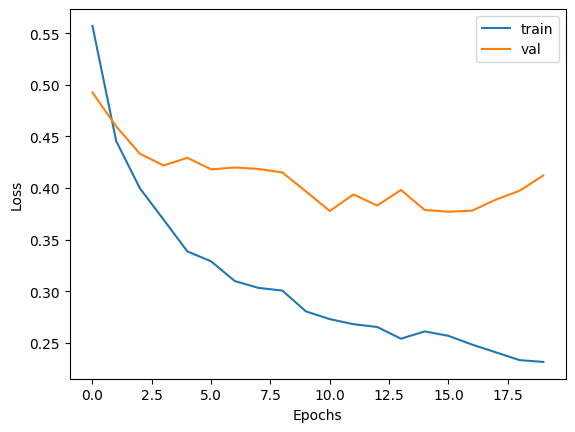

In [68]:
from matplotlib import pyplot as plt
plt.plot(rnn_model.result.history['loss'], label='train')
plt.plot(rnn_model.result.history['val_loss'], label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [71]:
loss, accuracy, auc, f1 = rnn_model.evaluate(X_test_input, y_test)

15/15 [==============================] - 7s 42ms/step - loss: 0.3447 - binary_accuracy: 0.8793 - auc: 0.9195 - f1_score: 0.7228


## Saving model

In [153]:
if not os.path.exists('saved_results/RNN_weights.h5'):
    rnn_model.save('saved_results/RNN_weights.h5', 'saved_results/RNN_config.json')